In [ ]:
!pip install nltk

In [ ]:
import nltk
import os
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
import numpy as np
from gensim.models import Nmf
from gensim.models.ldamodel import LdaModel
from gensim.models import LsiModel
from gensim.models import HdpModel
from gensim.models import LdaMulticore
from gensim.models import EnsembleLda
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
import gensim
import gensim.corpora as corpora
from gensim.models import Phrases
from gensim.utils import simple_preprocess
from gensim.corpora.dictionary import Dictionary
from gensim.utils import tokenize
from nltk.corpus import stopwords
from collections import Counter
nltk.download('stopwords')
nltk.download('wordnet')
import re
import json
import string
from bs4 import BeautifulSoup
from gensim.parsing.preprocessing import (
    strip_non_alphanum,
    split_alphanum,
    strip_short,
    strip_numeric
)
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
datafile = 'latest_ticket_data.csv'
data = pd.read_csv(datafile)

In [ ]:
def parse_html(text, parser="html.parser"):
    soup = BeautifulSoup(text, parser)
    soup = remove_html_tags(soup)
    text = remove_multiple_space(soup.get_text()).strip()
    return text


def parse_html_v2(text, loop=2, parser="html.parser"):
    if not text:
        text = ""
    # some contents still have html code after first parse
    # loop solved problem
    for _ in range(loop):
        soup = BeautifulSoup(text, parser)
        text = soup.get_text()
    text = remove_multiple_space(text)
    return text


def remove_links_content(text):
    text = re.sub(r"http\S+", "", text)
    return text


def remove_emails(text):
    return re.sub('\S*@\S*\s?', '', text)  # noqa


def remove_punctuation(text):
    """https://stackoverflow.com/a/37221663"""
    table = str.maketrans({key: None for key in string.punctuation})
    return text.translate(table)


def remove_special_tags(text):
    """Remove html tags from a string"""
    clean = re.compile('{.*?}')
    return re.sub(clean, '', text)


def preprocess_text(text):
    text = parse_html_v2(text)
    text = text.lower()
    text = remove_links_content(text)
    text = remove_emails(text)
    text = remove_special_tags(text)  # remove content between {}
    text = remove_punctuation(text)  # remove all puntuations
    text = split_alphanum(text)  # add space between word and numeric
    text = strip_numeric(text)  # remove digits
    text = strip_non_alphanum(text)  # remove non-alphabetic characters
    text = strip_short(text, minsize=2)  # remove word with length  <  minsize
    text = remove_multiple_space(text).strip()  # remove space and strip
    #text = tokenize(text)
    return text


def remove_multiple_space(text):
    return re.sub("\s\s+", " ", text)  # noqa


def remove_html_tags(soup,
                     tags=["script", "style"],
                     get_text=False):
    for tag in tags:
        for sample in soup.find_all(tag):
            sample.replaceWith('')

    if get_text:
        return soup.get_text()
    return soup

In [ ]:
# Convert body column to string for performing text operations
data['Description'] = data['Description'].astype(str)
data['Description'] =data["Description"].map(lambda x: preprocess_text(x))

In [ ]:
lemmatizer = WordNetLemmatizer()
data['Lemma_Description'] = data["Description"].map(lambda x: lemmatizer.lemmatize(x))

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))


x = data['Lemma_Description'].values.tolist()
docs = list(sent_to_words(x))
bigram = Phrases(docs, min_count=10)
trigram = Phrases(bigram[docs])

In [ ]:
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
    for token in trigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [ ]:
#Remove rare & common tokens
# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=10, no_above=0.2)
#Create dictionary and corpus required for Topic Modeling
corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))
print(corpus[:1])

Number of unique tokens: 1593
Number of documents: 3000
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]]


In [ ]:
# Set parameters.
num_topics = 5
chunksize = 500
passes = 20
iterations = 400
eval_every = 1

# Make a index to word dictionary.
temp = dictionary[0]  # only to "load" the dictionary.
id2word = dictionary

In [ ]:
LE = LabelEncoder()
data['Label'] = LE.fit_transform(data['Category'])
print(data)

                                            Description     Category  \
0     hi since recruiter lead permission approve req...  Application   
1     re expire days hi ask help update passwords co...  Application   
2     verification warning hi has got attached pleas...  Application   
3     please dear looks blacklisted receiving mails ...  Application   
4     dear modules report report cost thank much reg...  Application   
...                                                 ...          ...   
2995  sent tuesday feedback follow up conf call hell...     Database   
2996  sent monday issues hi keep getting errors whil...     Database   
2997  sent monday en working properly hi guys we hav...     Database   
2998  sent wednesday july hi please log incident for...     Database   
2999  sent tuesday july connection issues hello have...     Database   

                                      Lemma_Description  Label  
0     hi since recruiter lead permission approve req...      0  
1    

In [ ]:
from sklearn.metrics import accuracy_score
def getLDAModelAccuracy(model, corpus, dataset, Label):
  get_document_topics = [model.get_document_topics(item) for item in corpus]
  np_array_of_objects = np.asarray(get_document_topics, dtype="object")
  pred_df = pd.DataFrame(columns=['pred_label'])
  length = len(pd.DataFrame(np_array_of_objects)[0])
  dict_list = []
  for i in range(0,length):
    count=len(pd.DataFrame(np_array_of_objects)[0][i])
    max=0
    for j in range(0,count):
      if(max < (pd.DataFrame(np_array_of_objects)[0][i])[j][1]):
        max=(pd.DataFrame(np_array_of_objects)[0][i])[j][1]
        label=(pd.DataFrame(np_array_of_objects)[0][i])[j][0]
    row_dict = {'pred_label': label}
    dict_list.append(row_dict)
  pred_df = pd.DataFrame.from_dict(dict_list)
  y_pred = pred_df['pred_label'].values
  y_true = dataset['Label'].values
  return(accuracy_score(y_true, y_pred))

In [ ]:
#lda model
lda_model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)
# Print the Keyword in the 5 topics
print(lda_model.print_topics())

[(0, '0.040*"kind_regards" + 0.026*"best_regards" + 0.017*"re" + 0.016*"kind" + 0.015*"cards" + 0.015*"pm" + 0.011*"best" + 0.010*"help" + 0.010*"card" + 0.010*"dear"'), (1, '0.032*"thank_you" + 0.031*"you" + 0.020*"for" + 0.020*"could_you" + 0.018*"sent_monday" + 0.017*"sent_tuesday" + 0.016*"sent_wednesday" + 0.016*"sent_friday" + 0.016*"access" + 0.015*"with"'), (2, '0.021*"kind_regards" + 0.015*"event" + 0.012*"log" + 0.011*"by" + 0.009*"kind" + 0.009*"link" + 0.009*"update" + 0.008*"meeting_room" + 0.008*"changed" + 0.008*"software"'), (3, '0.038*"details" + 0.036*"leaver" + 0.030*"details_details" + 0.027*"did_leaver" + 0.027*"july_pm" + 0.022*"event" + 0.022*"engineer_ext" + 0.019*"data_event" + 0.019*"event_notification" + 0.018*"door"'), (4, '0.039*"card" + 0.036*"la" + 0.033*"si" + 0.031*"visitor" + 0.024*"va" + 0.023*"re" + 0.021*"visitor_cards" + 0.020*"pm" + 0.019*"ca" + 0.016*"care"')]


In [ ]:
getLDAModelAccuracy(lda_model,corpus,data,"Label")

0.36666666666666664

In [ ]:
c_v_coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
c_v_coherence_lda = c_v_coherence_model_lda.get_coherence()
print('\nC_V Coherence Score: ', c_v_coherence_lda)


C_V Coherence Score:  0.45232705634193665


In [ ]:
u_mass_coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='u_mass')
u_mass_coherence_lda = u_mass_coherence_model_lda.get_coherence()
print('\nU_Mass Coherence Score: ', u_mass_coherence_lda)


U_Mass Coherence Score:  -5.37948423729918


In [ ]:
c_uci_coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_uci')
c_uci_coherence_lda = c_uci_coherence_model_lda.get_coherence()
print('\nc_uciCoherence Score: ', c_uci_coherence_lda)


c_uciCoherence Score:  -4.644599893462358


In [ ]:
c_npmi_coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_npmi')
c_npmi_coherence_lda = c_npmi_coherence_model_lda.get_coherence()
print('\c_npmi_Coherence Score: ', c_npmi_coherence_lda)

\c_npmi_Coherence Score:  -0.13046830144987856


In [ ]:
#lda multicore model
lda_multicore_model = LdaMulticore(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)
# Print the Keyword in the 5 topics
print(lda_multicore_model.print_topics())

[(0, '0.025*"best_regards" + 0.024*"kind_regards" + 0.013*"re" + 0.010*"kind" + 0.010*"best" + 0.009*"dear" + 0.009*"by" + 0.009*"help" + 0.008*"has" + 0.008*"engineer"'), (1, '0.044*"card" + 0.030*"la" + 0.026*"si" + 0.025*"re" + 0.023*"pm" + 0.021*"analyst_ext" + 0.021*"cards" + 0.020*"visitor" + 0.017*"va" + 0.016*"ca"'), (2, '0.045*"kind_regards" + 0.022*"purchase_po" + 0.020*"name" + 0.020*"item" + 0.018*"log_allocation" + 0.018*"administrator" + 0.017*"kind" + 0.017*"printer" + 0.017*"po" + 0.017*"dear_purchased"'), (3, '0.036*"event" + 0.028*"lost_access" + 0.022*"details" + 0.021*"leaver" + 0.021*"disk" + 0.020*"did_leaver" + 0.019*"details_details" + 0.016*"door" + 0.016*"original_message" + 0.012*"did"'), (4, '0.032*"thank_you" + 0.030*"you" + 0.019*"could_you" + 0.018*"for" + 0.017*"sent_monday" + 0.016*"sent_wednesday" + 0.016*"sent_tuesday" + 0.016*"sent_friday" + 0.015*"access" + 0.014*"have"')]


In [ ]:
getLDAModelAccuracy(lda_multicore_model,corpus,data,"Label")

0.217

In [ ]:
c_v_coherence_model_lda_multicore = CoherenceModel(model=lda_multicore_model, texts=docs, dictionary=dictionary, coherence='c_v')
c_v_coherence_lda_multicore = c_v_coherence_model_lda_multicore.get_coherence()
print('\nC_V Coherence Score: ', c_v_coherence_lda_multicore)


C_V Coherence Score:  0.543319634848088


In [ ]:
u_mass_coherence_model_lda_multicore = CoherenceModel(model=lda_multicore_model, texts=docs, dictionary=dictionary, coherence='u_mass')
u_mass_coherence_lda_multicore = u_mass_coherence_model_lda_multicore.get_coherence()
print('\nu_mass Coherence Score: ', u_mass_coherence_lda_multicore)


u_mass Coherence Score:  -4.492673509482906


In [ ]:
c_uci_coherence_model_lda_multicore = CoherenceModel(model=lda_multicore_model, texts=docs, dictionary=dictionary, coherence='c_uci')
c_uci_coherence_lda_multicore = c_uci_coherence_model_lda_multicore.get_coherence()
print('\nc_uci Coherence Score: ', c_uci_coherence_lda_multicore)


c_uci Coherence Score:  -3.8909027158399163


In [ ]:
c_npmi_coherence_model_lda_multicore = CoherenceModel(model=lda_multicore_model, texts=docs, dictionary=dictionary, coherence='c_npmi')
c_npmi_coherence_lda_multicore = c_npmi_coherence_model_lda_multicore.get_coherence()
print('\nc_npmi Coherence Score: ', c_npmi_coherence_lda_multicore)


c_npmi Coherence Score:  -0.06853821865857293


In [ ]:
!pip install nltk

In [ ]:
import nltk
from nltk.stem import PorterStemmer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

In [ ]:
df_0 = data.loc[(data['Label'] == 0)]
df_1 = data.loc[(data['Label'] == 1)]
df_2 = data.loc[(data['Label'] == 2)]
df_3 = data.loc[(data['Label'] == 3)]
df_4 = data.loc[(data['Label'] == 4)]

In [ ]:
# Instantiate
vectorizer = TfidfVectorizer()
# Fit the data
tfidf = vectorizer.fit_transform(df_0['Description'])
# Create a dataframe of TFIDF
tfidf_df = pd.DataFrame(tfidf[0].T.todense(),
                      index=vectorizer.get_feature_names_out(),
                      columns=["TF-IDF"])
# Sort
tfidf_df = tfidf_df.sort_values('TF-IDF', ascending=False)
label_0 = [tfidf_df.index[0],tfidf_df.index[1],tfidf_df.index[2],tfidf_df.index[3],tfidf_df.index[4]]

In [ ]:
# Instantiate
vectorizer = TfidfVectorizer()
# Fit the data
tfidf = vectorizer.fit_transform(df_1['Description'])
# Create a dataframe of TFIDF
tfidf_df = pd.DataFrame(tfidf[0].T.todense(),
                      index=vectorizer.get_feature_names_out(),
                      columns=["TF-IDF"])
# Sort
tfidf_df = tfidf_df.sort_values('TF-IDF', ascending=False)
label_1 = [tfidf_df.index[0],tfidf_df.index[1],tfidf_df.index[2],tfidf_df.index[3],tfidf_df.index[4]]

In [ ]:
# Instantiate
vectorizer = TfidfVectorizer()
# Fit the data
tfidf = vectorizer.fit_transform(df_2['Description'])
# Create a dataframe of TFIDF
tfidf_df = pd.DataFrame(tfidf[0].T.todense(),
                      index=vectorizer.get_feature_names_out(),
                      columns=["TF-IDF"])
# Sort
tfidf_df = tfidf_df.sort_values('TF-IDF', ascending=False)
label_2 = [tfidf_df.index[0],tfidf_df.index[1],tfidf_df.index[2],tfidf_df.index[3],tfidf_df.index[4]]

In [ ]:
# Instantiate
vectorizer = TfidfVectorizer()
# Fit the data
tfidf = vectorizer.fit_transform(df_3['Description'])
# Create a dataframe of TFIDF
tfidf_df = pd.DataFrame(tfidf[0].T.todense(),
                      index=vectorizer.get_feature_names_out(),
                      columns=["TF-IDF"])
# Sort
tfidf_df = tfidf_df.sort_values('TF-IDF', ascending=False)
label_3 = [tfidf_df.index[0],tfidf_df.index[1],tfidf_df.index[2],tfidf_df.index[3],tfidf_df.index[4]]

In [ ]:
# Instantiate
vectorizer = TfidfVectorizer()
# Fit the data
tfidf = vectorizer.fit_transform(df_4['Description'])
# Create a dataframe of TFIDF
tfidf_df = pd.DataFrame(tfidf[0].T.todense(),
                      index=vectorizer.get_feature_names_out(),
                      columns=["TF-IDF"])
# Sort
tfidf_df = tfidf_df.sort_values('TF-IDF', ascending=False)
label_4 = [tfidf_df.index[0],tfidf_df.index[1],tfidf_df.index[2],tfidf_df.index[3],tfidf_df.index[4]]

In [ ]:
ps = PorterStemmer()

label_0 = [ps.stem(word) for word in label_0]
label_1 = [ps.stem(word) for word in label_1]
label_2 = [ps.stem(word) for word in label_2]
label_3 = [ps.stem(word) for word in label_3]
label_4 = [ps.stem(word) for word in label_4]

In [ ]:
label_topics = {}
for word in label_0:
    label_topics[word] = 0
for word in label_1:
    label_topics[word] = 1
for word in label_2:
    label_topics[word] = 2
for word in label_3:
    label_topics[word] = 3
for word in label_4:
    label_topics[word] = 4

In [ ]:
def create_eta(priors, etadict, ntopics):
    eta = np.full(shape=(ntopics, len(etadict)), fill_value=1) # create a (ntopics, nterms) matrix and fill with 1
    for word, topic in priors.items(): # for each word in the list of priors
        keyindex = [index for index,term in etadict.items() if term==word] # look up the word in the dictionary
        if (len(keyindex)>0): # if it's in the dictionary
            eta[topic,keyindex[0]] = 1e7  # put a large number in there
    eta = np.divide(eta, eta.sum(axis=0)) # normalize so that the probabilities sum to 1 over all topics
    return eta

In [ ]:
eta_label = create_eta(label_topics, dictionary, 5)

In [ ]:
#lda model
label_lda_model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta=eta_label, \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)

In [ ]:
getLDAModelAccuracy(label_lda_model,corpus,data,"Label")

0.182

In [ ]:
for num, params in label_lda_model.print_topics():
    print(f'{num}: {params}\n')

0: 0.040*"best_regards" + 0.039*"card" + 0.033*"pm" + 0.025*"re" + 0.024*"la" + 0.022*"si" + 0.016*"va" + 0.014*"best" + 0.013*"ca" + 0.012*"friday_pm"

1: 0.040*"leaver" + 0.039*"disk" + 0.031*"did_leaver" + 0.030*"down" + 0.022*"meeting_room" + 0.020*"if_problem" + 0.020*"changed" + 0.020*"did" + 0.018*"maternity_leaver" + 0.018*"leaver_form"

2: 0.036*"thank_you" + 0.035*"you" + 0.022*"could_you" + 0.022*"for" + 0.021*"sent_monday" + 0.020*"sent_tuesday" + 0.019*"sent_wednesday" + 0.018*"sent_friday" + 0.018*"access" + 0.016*"with"

3: 0.036*"kind_regards" + 0.015*"kind" + 0.012*"event" + 0.011*"details" + 0.011*"re" + 0.010*"analyst_ext" + 0.009*"by" + 0.009*"name" + 0.008*"please_advise" + 0.006*"secure_area"

4: 0.039*"visitor" + 0.027*"visitor_cards" + 0.019*"kind_regards" + 0.016*"item" + 0.014*"visitor_visitor" + 0.012*"upgrade" + 0.012*"purchase_po" + 0.012*"design_lead" + 0.010*"log_allocation" + 0.010*"information"



In [ ]:
c_v_coherence_model_labellda = CoherenceModel(model=label_lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
c_v_coherence_labellda = c_v_coherence_model_labellda.get_coherence()
print('\nC_V Coherence Score: ', c_v_coherence_labellda)


C_V Coherence Score:  0.49030501898691226


In [ ]:
u_mass_coherence_model_lda = CoherenceModel(model=label_lda_model, texts=docs, dictionary=dictionary, coherence='u_mass')
u_mass_coherence_lda = u_mass_coherence_model_lda.get_coherence()
print('\nU_Mass Coherence Score: ', u_mass_coherence_lda)


U_Mass Coherence Score:  -6.797105043050583


In [ ]:
c_uci_coherence_model_lda = CoherenceModel(model=label_lda_model, texts=docs, dictionary=dictionary, coherence='c_uci')
c_uci_coherence_lda = c_uci_coherence_model_lda.get_coherence()
print('\nc_uciCoherence Score: ', c_uci_coherence_lda)


c_uciCoherence Score:  -6.110775453881483


In [ ]:
c_npmi_coherence_model_lda = CoherenceModel(model=label_lda_model, texts=docs, dictionary=dictionary, coherence='c_npmi')
c_npmi_coherence_lda = c_npmi_coherence_model_lda.get_coherence()
print('\c_npmi_Coherence Score: ', c_npmi_coherence_lda)

\c_npmi_Coherence Score:  -0.18901347020415077


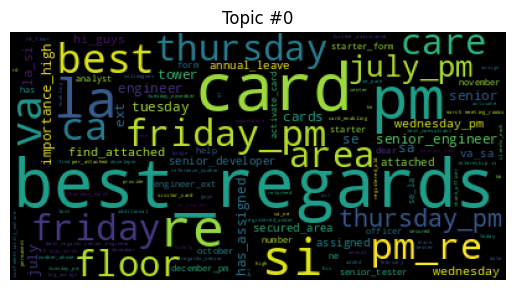

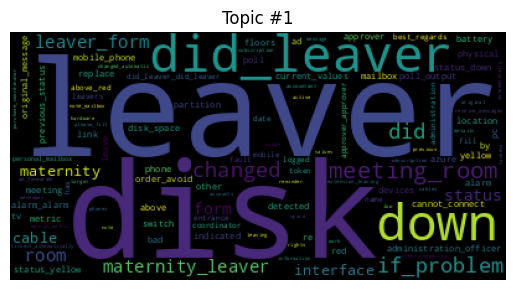

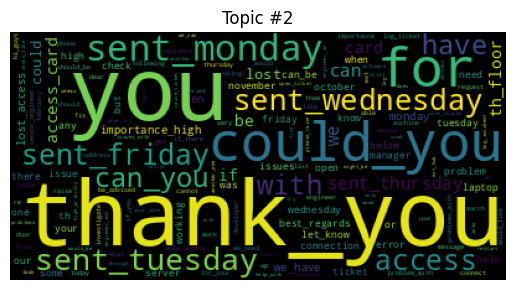

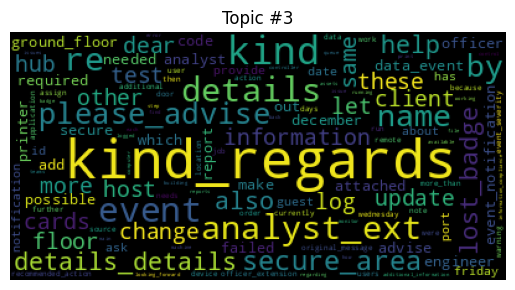

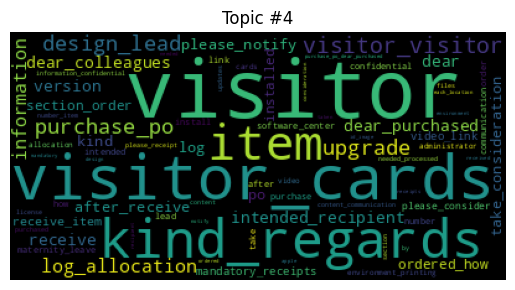

In [ ]:
for t in range(label_lda_model.num_topics):
    plt.figure()
    plt.imshow(WordCloud().fit_words(dict(label_lda_model.show_topic(t, 200))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

In [ ]:
label_ldamulti_model = LdaMulticore(corpus=corpus,
                         id2word=id2word,
                         num_topics=num_topics,
                         eta=eta_label,
                         chunksize=chunksize,
                         passes=passes,
                         iterations=iterations,
                         eval_every = eval_every,
                         random_state=42,
                         per_word_topics=True)

In [ ]:
getLDAModelAccuracy(label_ldamulti_model,corpus,data,"Label")

0.18566666666666667

In [ ]:
for num, params in label_ldamulti_model.print_topics():
    print(f'{num}: {params}\n')

0: 0.030*"thank_you" + 0.028*"you" + 0.018*"could_you" + 0.017*"for" + 0.016*"sent_monday" + 0.015*"sent_wednesday" + 0.015*"sent_friday" + 0.014*"with" + 0.014*"can_you" + 0.013*"have"

1: 0.036*"kind_regards" + 0.029*"has_assigned" + 0.029*"item" + 0.024*"log" + 0.022*"purchase_po" + 0.018*"log_allocation" + 0.017*"dear_purchased" + 0.017*"receive" + 0.017*"po" + 0.016*"after_receive"

2: 0.029*"event" + 0.027*"th_floor" + 0.026*"card" + 0.021*"access_card" + 0.021*"lost" + 0.021*"visitor" + 0.020*"disk" + 0.016*"visitor_cards" + 0.015*"lost_access" + 0.014*"floor"

3: 0.024*"kind_regards" + 0.019*"best_regards" + 0.013*"re" + 0.010*"kind" + 0.009*"name" + 0.009*"by" + 0.009*"help" + 0.008*"leaver" + 0.008*"dear" + 0.008*"pm"

4: 0.037*"card" + 0.031*"la" + 0.030*"si" + 0.030*"pm" + 0.027*"re" + 0.025*"best_regards" + 0.021*"va" + 0.021*"analyst_ext" + 0.018*"senior_engineer" + 0.017*"ca"



In [ ]:
c_v_coherence_model_labelldamulti = CoherenceModel(model=label_ldamulti_model, texts=docs, dictionary=dictionary, coherence='c_v')
c_v_coherence_labelldamulti = c_v_coherence_model_labelldamulti.get_coherence()
print('\nC_V Coherence Score: ', c_v_coherence_labelldamulti)


C_V Coherence Score:  0.5318360612958857


In [ ]:
u_mass_coherence_model_lda_multicore = CoherenceModel(model=label_ldamulti_model, texts=docs, dictionary=dictionary, coherence='u_mass')
u_mass_coherence_lda_multicore = u_mass_coherence_model_lda_multicore.get_coherence()
print('\nu_mass Coherence Score: ', u_mass_coherence_lda_multicore)


u_mass Coherence Score:  -3.4047633031152396


In [ ]:
c_uci_coherence_model_lda_multicore = CoherenceModel(model=lda_multicore_model, texts=docs, dictionary=dictionary, coherence='c_uci')
c_uci_coherence_lda_multicore = c_uci_coherence_model_lda_multicore.get_coherence()
print('\nc_uci Coherence Score: ', c_uci_coherence_lda_multicore)


c_uci Coherence Score:  -3.8909027158399163


In [ ]:
c_npmi_coherence_model_lda_multicore = CoherenceModel(model=lda_multicore_model, texts=docs, dictionary=dictionary, coherence='c_npmi')
c_npmi_coherence_lda_multicore = c_npmi_coherence_model_lda_multicore.get_coherence()
print('\nc_npmi Coherence Score: ', c_npmi_coherence_lda_multicore)


c_npmi Coherence Score:  -0.06853821865857293


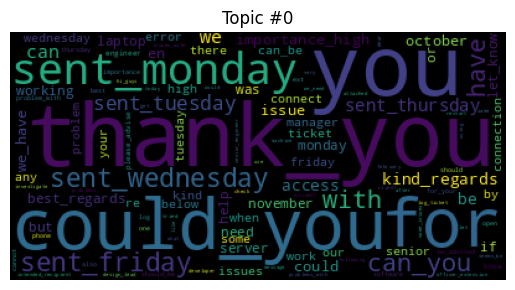

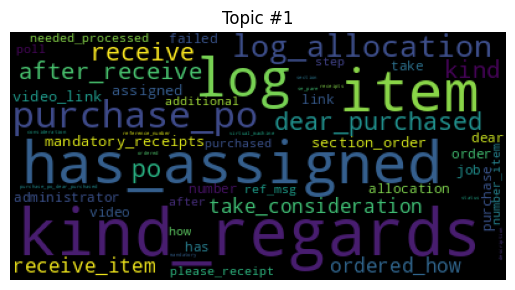

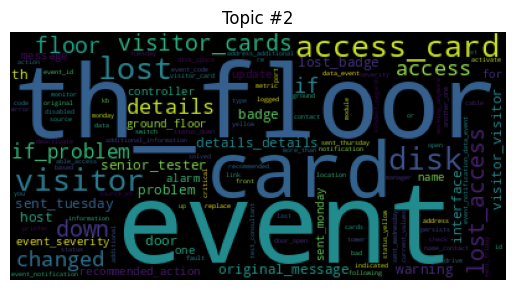

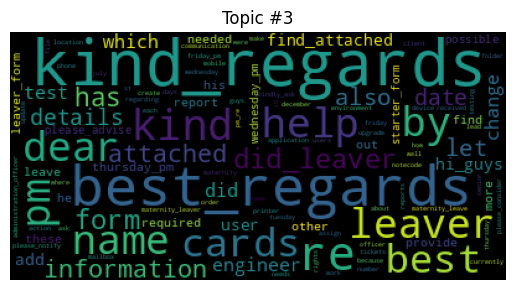

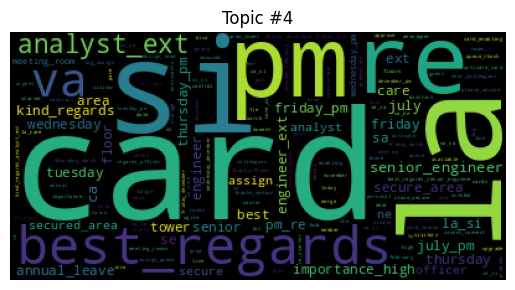

In [ ]:
for t in range(label_ldamulti_model.num_topics):
    plt.figure()
    plt.imshow(WordCloud().fit_words(dict(label_ldamulti_model.show_topic(t, 200))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()